In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from concurrent.futures import ProcessPoolExecutor
# sns.set()

# Training Performance over iterations 

## Visualize Frechet Inception Distance per Epoch

In [7]:
model1 = pd.read_csv("results/logs/Aug14_08-04-23_overdrive/Aug14_08-04-23_overdrive.csv")
model2 = pd.read_csv("results/logs/Aug15_20-22-52_overdrive/Aug15_20-22-52_overdrive.csv")
model3 = pd.read_csv("results/logs/Aug20_16-16-29_overdrive/Frechet Inception Distance.csv")
model4 = pd.read_csv("results/logs/Aug24_16-55-03_overdrive/Frechet Inception Distance.csv")

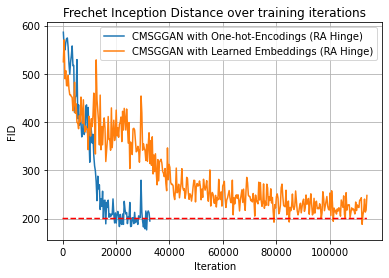

In [9]:
plt.figure()
sns.lineplot(data=model2, x='Step', y='Value')
sns.lineplot(data=model1, x='Step', y='Value')
plt.plot([200]*list(model1["Step"])[-1], "r--")
plt.legend(["CMSGGAN with One-hot-Encodings (RA Hinge)", "CMSGGAN with Learned Embeddings (RA Hinge)"])
plt.title("Frechet Inception Distance over training iterations")
plt.xlabel("Iteration")
plt.ylabel("FID")
plt.savefig("results/logs/FIDs.jpg")
plt.grid()
plt.show()
plt.close()

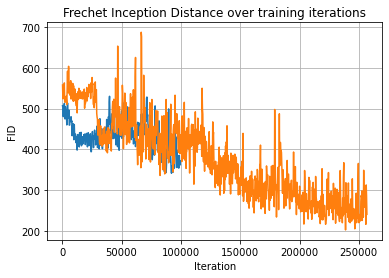

In [15]:
plt.figure()
sns.lineplot(data=model3, x='Step', y='Value')
sns.lineplot(data=model4, x='Step', y='Value')
plt.title("Frechet Inception Distance over training iterations")
plt.xlabel("Iteration")
plt.ylabel("FID")
plt.grid()
plt.show()
plt.close()

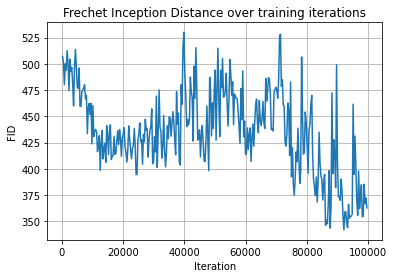

In [17]:
plt.figure()
sns.lineplot(data=model3, x='Step', y='Value')
plt.title("Frechet Inception Distance over training iterations")
plt.xlabel("Iteration")
plt.ylabel("FID")
plt.savefig("results/logs/cmsggan2_wgangp_FIDs.jpg")
plt.grid()
plt.show()
plt.close()

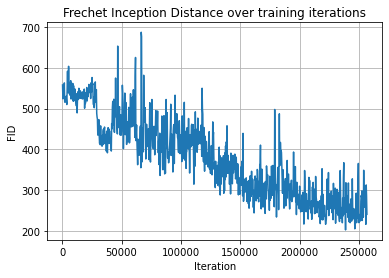

In [16]:
plt.figure()
sns.lineplot(data=model4, x='Step', y='Value')
plt.title("Frechet Inception Distance over training iterations")
plt.xlabel("Iteration")
plt.ylabel("FID")
plt.savefig("results/logs/cmsggan1_wgangp_FIDs.jpg")
plt.grid()
plt.show()
plt.close()

# Qualitative Evaluation

## Visualize Generated Images per Gene

In [ ]:
def create_image_grid(results_dir, classes="all", figsize=(6,50), save_as=None):
    plt.close()
    
    cols = ['Image {}'.format(i+1) for i in range(5)]
    if classes == "all":
        rows = os.listdir(results_dir)
    else:
        rows = classes
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(len(rows), len(cols), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    axes = axes[None, :] if len(rows) == 1 else axes

    for ax, col in zip(axes[0], cols):
        ax.set_title(col)
        
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='large')
        
    for i, c in enumerate(rows):
        images_list = sorted(os.listdir(os.path.join(results_dir, c)))[:5]
        for j, f in enumerate(images_list):
            img = plt.imread(os.path.join(results_dir, c, f))
            axes[i, j].imshow(img, cmap=plt.cm.gray)
            axes[i, j].set_yticklabels([])
            axes[i, j].set_xticklabels([])
            axes[i, j].tick_params(left=False, bottom=False)
    fig.tight_layout()
    return fig

In [ ]:
with open("classes.txt", 'r') as f:
    classes = f.read().splitlines()
results_dir = "results/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_100/generated_examples"
cl = ["ABCA4", "USH2A", "RPGR", "BEST1", "PRPH2", "RS1", "TIMP3", "PROML1"]
create_image_grid(results_dir, classes=cl, figsize=(7.5, 12))

In [ ]:
with open("classes.txt", 'r') as f:
    classes = f.read().splitlines()
results_dir = "results/data:all_baf_valid_50deg_filtered3.csvclasses:classes.txt_trans:256-1-1_mod:cmsgganv2-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_350/generated_examples"
cl = ["ABCA4", "USH2A", "RPGR", "BEST1", "PRPH2", "RS1", "TIMP3", "PROML1"]
create_image_grid(results_dir, classes=cl, figsize=(7.5, 12))

# Quantitative Evaluation

## Compute class predictions by Eye2Gene

In [ ]:
def compute_class_confidence(imgs, return_labels=True):

    # install libraries
    import tensorflow as tf
    import json
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    # load images
    if isinstance(imgs, (torch.FloatTensor, np.ndarray)):
        images = imgs[:, :, :, None].repeat(3, -1)
    else:
        images = np.zeros((len(imgs), 256, 256, 3))
        for i, img in enumerate(imgs):
            images[i, :, :, :] = plt.imread(img)[:, :, None].repeat(3, -1)
            
    preprocess_func = tf.keras.applications.inception_v3.preprocess_input
    images = preprocess_func(images)

    # load pretrained eye2gene classifier
    from models.eye2gene.base import Model
    model_paths = os.listdir("models/eye2gene/weights/")
    model_paths = [os.path.join("models/eye2gene/weights", path) for path in model_paths if path.endswith(".h5")]
    
    conf = np.zeros((50, 36))
    for path in model_paths:
        model = Model().load(path)
        conf += model.predict(images)
    conf = np.divide(conf, len(model_paths))
    
    # create index to labels converter
    config_path = model_paths[0][:-3] + '.json'
    with open(config_path, 'r') as config_file:
        model_config = json.load(config_file)
    
    df = pd.DataFrame(conf, columns=model_config['classes'])

    return df

In [ ]:
results_dir = "results/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_100/generated_examples"

confidences = []
for c in sorted(os.listdir(results_dir)):
    plt.close()
    print(c)
    images = sorted(os.listdir(os.path.join(results_dir, c)))
    images = [os.path.join(results_dir, c, images[i]) for i in range(len(images))]
    confidences.append(compute_class_confidence(images))

In [ ]:
confidences_2 = pd.concat([confidences[i].idxmax(axis=1) for i in range(len(confidences))], axis=1)
confusions = pd.DataFrame(0, index=sorted(os.listdir(results_dir)), columns=sorted(os.listdir(results_dir)))
for i, col in enumerate(confusions.columns):
    confusions[col] = confusions[col].combine(confidences_2[i].value_counts(normalize=0), max)

In [ ]:
plt.close()
plt.figure(figsize=(20, 10))
sns.heatmap(confusions, annot=True)
plt.xlabel("Actual Class of Image")
plt.ylabel("Predicted Class by Eye2Gene")
plt.show()

## Experiment 2: Generate completely random images and study confusions 

In [ ]:
from helpers.data_utils import ImageDataset
from generators.msggan_gen import generate

In [ ]:
cls, sizes = np.unique(dataset.img_labels, return_counts=True)
cls[np.argsort(sizes)][::-1]

In [ ]:
torch.manual_seed(1399)
torch.cuda.manual_seed(1399)

latent_size = 512
n_samples = 50
resolution = 256
dataset = ImageDataset('datasets/all_baf_valid_50deg_filtered3.csv',
                       'file.path',
                       'gene',
                       'classes.txt')
classes = dataset.classes
class_mapping = dataset.class2idx
generate_randomly = True
weights_path = "checkpoints/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_100.pth"
model_name = "cmsggan"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

generated_images = generate(latent_size,
                            n_samples,
                            resolution, 
                            True, 
                            classes,
                            class_mapping,
                            generate_randomly,
                            weights_path,
                            model_name,
                            device)
generated_images = generated_images*255

In [ ]:
results_dir = "results/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_100/generated_examples"
confidences = []
for c in classes:
    print(c)
    idx = class_mapping[c]
    confidences.append(compute_class_confidence(generated_images[idx, :, :, :].numpy()))

In [ ]:
# confidences_2 = pd.concat([confidences[i].idxmax(axis=1) for i in range(len(confidences))], axis=1)
confusions = pd.DataFrame(0, index=classes, columns=classes)
for i, col in enumerate(confusions.columns):
    confusions[col] = confusions[col].combine(confidences_2[i].value_counts(normalize=0), max)
    
plt.close()
plt.figure(figsize=(20, 10))
sns.heatmap(confusions, annot=True)
plt.xlabel("Actual Class of Image")
plt.ylabel("Predicted Class by Eye2Gene")
plt.show()

In [ ]:
from helpers.evaluate import compute_fid_eye2gene
from helpers.data_utils import ImageDataset
from torchvision import transforms

In [ ]:
def compute_fid_eye2gene(gen_imgs, real_imgs):
    """ Computes frechet inception distance using our Eye2Gene pretrained weights model """

    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    import tensorflow as tf
    import scipy

    def preprocess(imgs):
        """ Resizes tensors for Eye2gene model """
        imgs = imgs.detach().numpy()
        imgs = imgs[:, :, :, None]
        imgs = np.repeat(imgs, 3, -1)
        return imgs

    # separate preprocess function just for inceptionv3
    inception_preprocess_func = tf.keras.applications.inception_v3.preprocess_input

    # preprocess generated and real images
    gen_imgs, real_imgs = preprocess(gen_imgs), preprocess(real_imgs)
    gen_imgs, real_imgs = inception_preprocess_func(gen_imgs), inception_preprocess_func(real_imgs)

    # load model
    model_paths = os.listdir("models/eye2gene/weights/")
    model_paths = [os.path.join("models/eye2gene/weights", path) for path in model_paths if path.endswith(".h5")]
    
    inception_model_full = tf.keras.applications.InceptionV3(include_top=True,
                                                             classes=36,
                                                             weights=None,
                                                             input_shape=(256, 256, 3),
                                                             pooling='max')
    inception_model = tf.keras.Model(inputs=inception_model_full.input, outputs=inception_model_full.layers[-2].output)

    # helper functions
    def matrix_sqrt(x):
        y = scipy.linalg.sqrtm(x)
        if np.iscomplexobj(y):
            y = y.real
        return y

    def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
        return (mu_x - mu_y).dot(mu_x - mu_y) + np.trace(sigma_x) + np.trace(sigma_y) - \
               2*np.trace(matrix_sqrt(sigma_x @ sigma_y))

    def get_covariance(features):
        return np.cov(features, rowvar=False)

    # ============================
    # Get the image features
    # ============================
    gen_features_all = np.zeros((50, 2048))
    real_features_all = np.zeros((50, 2048))
    for path in model_paths:
        inception_model_full.load_weights(path)
        gen_features_all += inception_model.predict(gen_imgs)
        real_features_all += inception_model.predict(real_imgs)
        
    gen_features_all = gen_features_all / 5
    real_features_all = real_features_all / 5
    
    # ============================
    # Calculate feature statistics
    # ============================

    # calculate mean across all observations
    mu_fake = gen_features_all.mean(0)
    mu_real = real_features_all.mean(0)

    # calculate covariance
    sigma_fake = get_covariance(gen_features_all)
    sigma_real = get_covariance(real_features_all)

    fid = frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake)

    return fid

In [ ]:
generated_imgs = torch.load("gen_imgs.pt")

In [ ]:
torch.manual_seed(1399)
np.random.seed(1399)
# load real images
image_transforms = []
# image resizing
image_transforms.append(transforms.Resize((256, 256)))
image_transforms.append(transforms.Grayscale())
image_transforms.append(transforms.ToTensor())
image_transforms = transforms.Compose(image_transforms)
data = ImageDataset("datasets/all_baf_valid_50deg_filtered3.csv", "file.path", "gene", ["ABCA4"], image_transforms)
real_samples = data.get_samples(50)

## Visualize FID scores

In [2]:
with open("classes.txt", 'r') as f:
    classes = f.read().splitlines()

In [3]:
# model 1
FID_cmsggan1_imagenet = pd.read_csv("results/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_100/metrics/fid_imagenet/fid_imagenet_scores_per_class.csv")
FID_cmsggan1_eye2gene = pd.read_csv("results/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_100/metrics/fid_eye2gene/fid_eye2gene_scores_per_class.csv")
# model 2
FID_cmsggan2_imagenet = pd.read_csv("results/data:all_baf_valid_50deg_filtered3.csvclasses:classes.txt_trans:256-1-1_mod:cmsgganv2-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_350/metrics/fid_imagenet/fid_imagenet_scores_per_class.csv")
FID_cmsggan2_eye2gene = pd.read_csv("results/data:all_baf_valid_50deg_filtered3.csvclasses:classes.txt_trans:256-1-1_mod:cmsgganv2-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/model_ema_state_350/metrics/fid_eye2gene/fid_eye2gene_scores_per_class.csv")

In [4]:
# model_1
FID_cmsggan1_imagenet["log_FID"] = np.log(FID_cmsggan1_imagenet["0"])
FID_cmsggan1_eye2gene["log_FID"] = np.log(FID_cmsggan1_eye2gene["0"])
# model 2 
FID_cmsggan2_imagenet["log_FID"] = np.log(FID_cmsggan2_imagenet["0"])
FID_cmsggan2_eye2gene["log_FID"] = np.log(FID_cmsggan2_eye2gene["0"])

In [6]:
dataframes = [FID_cmsggan1_imagenet['Unnamed: 0'],
              FID_cmsggan1_imagenet["0"], 
              FID_cmsggan1_eye2gene["0"],
              FID_cmsggan2_imagenet["0"], 
              FID_cmsggan2_eye2gene["0"]]
metrics = pd.concat(dataframes, axis=1, ignore_index=True)
metrics.columns = ["Gene", "FID_cmsggan1_imagenet", "FID_cmsggan1_eye2gene", "FID_cmsggan2_imagenet", "FID_cmsggan2_eye2gene"]
metrics = pd.melt(metrics, id_vars=["Gene"], value_vars=metrics.columns[1:])
metrics

,Gene,variable,value
0,ABCA4,FID_cmsggan1_imagenet,180.322159
1,USH2A,FID_cmsggan1_imagenet,162.109558
2,RPGR,FID_cmsggan1_imagenet,158.746384
3,BEST1,FID_cmsggan1_imagenet,208.502106
4,PRPH2,FID_cmsggan1_imagenet,189.023331
...,...,...,...
139,RP1L1,FID_cmsggan2_eye2gene,49.778110
140,CYP4V2,FID_cmsggan2_eye2gene,54.937693
141,MTTL1,FID_cmsggan2_eye2gene,59.529627
142,OPA1,FID_cmsggan2_eye2gene,37.395849


<Figure size 640x480 with 0 Axes>

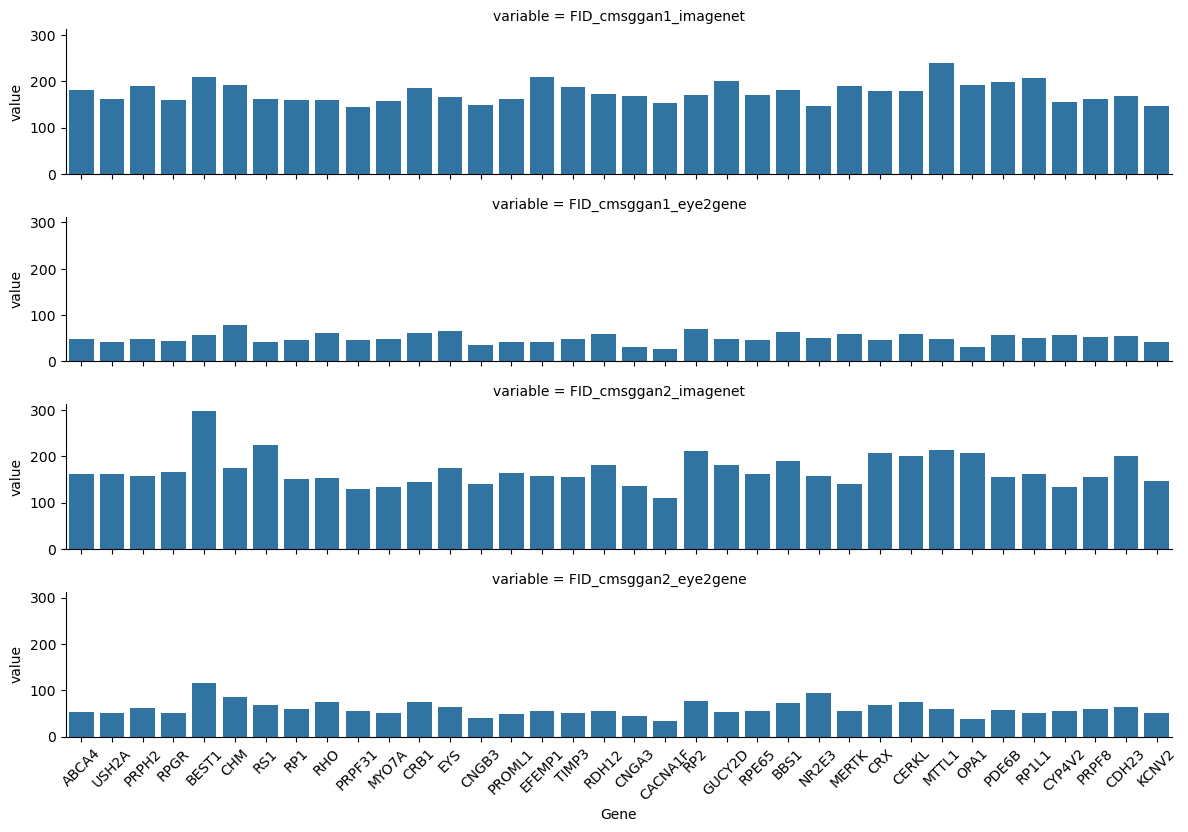

In [9]:
plt.figure()
g = sns.FacetGrid(metrics, row="variable", height=2, aspect=6)
g.map(sns.barplot, "Gene", "value", order=classes)
plt.xticks(rotation=45)
plt.show()
plt.close()

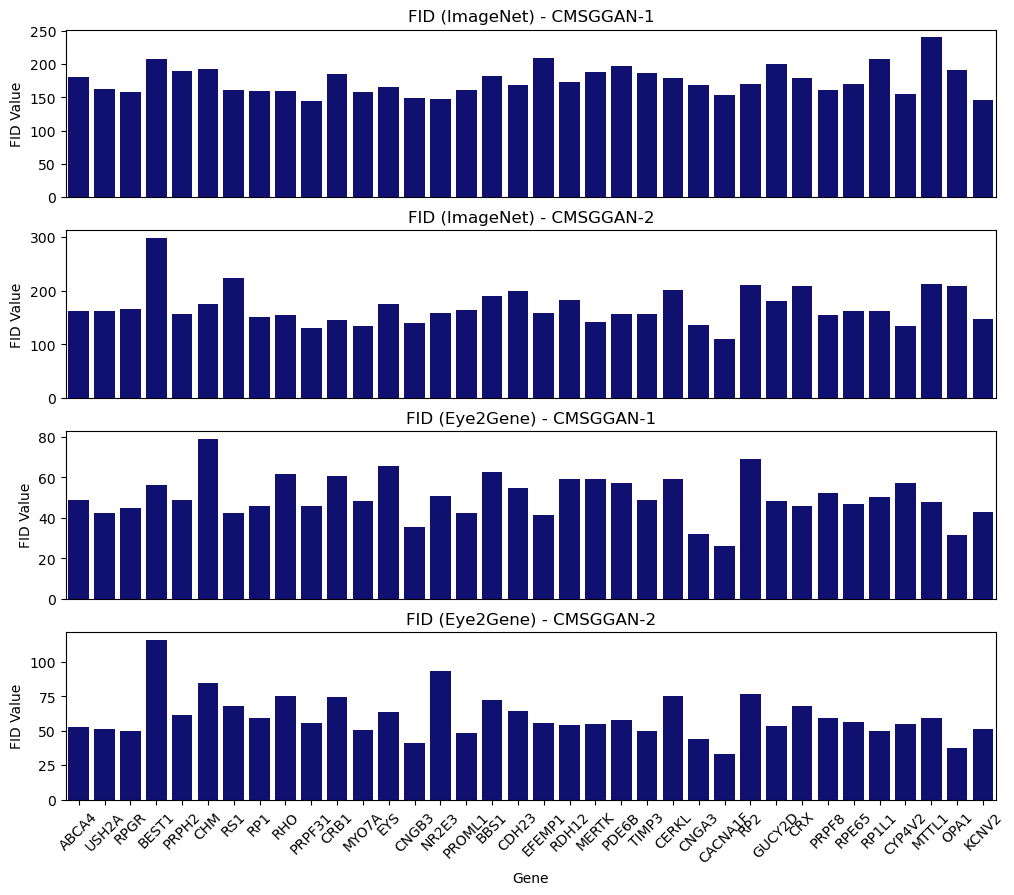

In [33]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.title("FID (ImageNet) - CMSGGAN-1")
sns.barplot(data=FID_cmsggan1_imagenet, x="Unnamed: 0", y="0", color="navy")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel(None)
plt.ylabel("FID Value")

plt.subplot(4, 1, 2)
plt.title("FID (ImageNet) - CMSGGAN-2")
sns.barplot(data=FID_cmsggan2_imagenet, x="Unnamed: 0", y="0", color="navy")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel(None)
plt.ylabel("FID Value")

plt.subplot(4, 1, 3)
plt.title("FID (Eye2Gene) - CMSGGAN-1")
sns.barplot(data=FID_cmsggan1_eye2gene, x="Unnamed: 0", y="0", color="navy")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel(None)
plt.ylabel("FID Value")

plt.subplot(4, 1, 4)
plt.title("FID (Eye2Gene) - CMSGGAN-2")
sns.barplot(data=FID_cmsggan2_eye2gene, x="Unnamed: 0", y="0", color="navy")

plt.xlabel("Gene")
plt.ylabel("FID Value")
plt.xticks(rotation=45)
plt.show()
plt.close()

In [31]:
FID_cmsggan1_eye2gene["0"].describe(), FID_cmsggan2_eye2gene["0"].describe()

(count    36.000000
 mean     50.389628
 std      10.854710
 min      25.946158
 25%      44.208504
 50%      48.728781
 75%      57.830436
 max      78.951096
 Name: 0, dtype: float64,
 count     36.000000
 mean      60.327653
 std       15.981716
 min       32.701773
 25%       50.823356
 50%       55.881366
 75%       67.624079
 max      115.824356
 Name: 0, dtype: float64)

In [14]:
# can check if the mean FID of the CMSGGAN-1 is significantly different from CMSGGAN-2
from scipy.stats import ttest_ind

ttest_ind(FID_cmsggan1_imagenet["0"], FID_cmsggan2_imagenet["0"])

Ttest_indResult(statistic=0.83049485670091, pvalue=0.4090826922334919)

# Visualize MI scores and most similar images

In [ ]:
def visualize_mutual_info(results_dir, figsize=(5, 1)):
    
    rows = 36
    cols = 1
    
    plt.close()
    
#     plt.figure(figsize=figsize)
    images_list = os.listdir(results_dir)
    images_list = [os.path.join(results_dir, img) for img in images_list if "MI_hist_" in img]
    
    for i in range(len(images_list)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(plt.imread(images_list[i]))
        plt.axis("off")
    
#     gs = fig.add_gridspec(rows, cols, hspace=0, wspace=0)
#     axes = gs.subplots(sharex='col', sharey='row')     
#     for i, c in enumerate(rows):
#         for j, f in enumerate(images_list):
#             img = plt.imread(images_list[])
#             axes[i, j].imshow(img, cmap=plt.cm.gray)
#             axes[i, j].set_yticklabels([])
#             axes[i, j].set_xticklabels([])

#     plt.tight_layout()
    plt.show()